Notebook on time series causality, part 1

## Imports

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as sm_form
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
np.random.seed(5000)

import rpy2
%load_ext rpy2.ipython

In [2]:
%%R 
library(dagitty)

In [3]:
#!curl -O "https://raw.githubusercontent.com/vitorcurtis/RWinOut/master/RWinOut.py

In [4]:
%load_ext RWinOut

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## DGP

$
\begin{align*}
Y_{1,t} & = b_{1,1} Y_{1,t-1} + u_{1,t} \\
Y_{2,t} & = b_{2,1} Y_{1,t-1} + b_{2,2} Y_{2,t-1} + u_{2,t} \\
\end{align*}
$

where $t \geq 1$ and $
\begin{align*}
Y_0 = \begin{bmatrix} Y_{1,0} \\ Y_{2,0} \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}
\end{align*}
$
and with $b_{1,1} = 0.8$, $b_{2,1} = -0.5$ and $b_{2,2} = 0.7$. 

Shocks are uncorrelated with covariance matrix:

$
\begin{align*}
\mathbf{\Sigma}_u = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\end{align*}
$

Directed acyclic graph of the DGP:

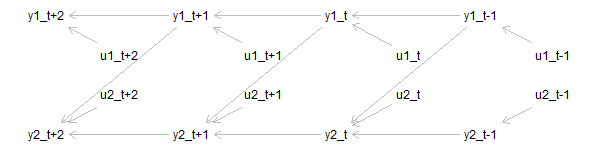

[1] "Adjustment set for u1_t direct effect on y2_t+1:"
 { y1_t, y2_t }
 { y1_t, y1_t-1 }
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+1:"
 {}
[1] "---------------------------------------------------------------------"
[1] "Adjustment set for u1_t direct effect on y2_t+2:"
 { y1_t+1, y2_t+1 }
 { y1_t, y2_t+1 }
 { y1_t, y2_t }
 { y1_t, y1_t-1 }
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+2:"
 {}


In [5]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "u1_t+2" [pos="1,2"]
    "u2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "u1_t+1" [pos="3,2"]
    "u2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "u1_t"   [pos="5,2"]
    "u2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "u1_t-1" [pos="7,2"]
    "u2_t-1" [pos="7,3"]    
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "u1_t+2"
    "y1_t+1" <- "u1_t+1"
    "y1_t"   <- "u1_t"
    "y1_t-1" <- "u1_t-1"
    "y2_t+2" <- "u2_t+2"
    "y2_t+1" <- "u2_t+1"
    "y2_t"   <- "u2_t"
    "y2_t-1" <- "u2_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t"   <- "y1_t-1"
}')
plot(g)

print("Adjustment set for u1_t direct effect on y2_t+1:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+1", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+1:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+1", effect="total"))
print("---------------------------------------------------------------------")
print("Adjustment set for u1_t direct effect on y2_t+2:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+2", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+2:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+2", effect="total"))

### Simualate data according to DGP

L1.y1.y1 :0.8
L1.y2.y1 :0.0
L1.y1.y2 :-0.5
L1.y2.y2 :0.7
sqrt.var.y1 :1.0
sqrt.cov.y1.y2 :0.0
sqrt.var.y2 :1.0


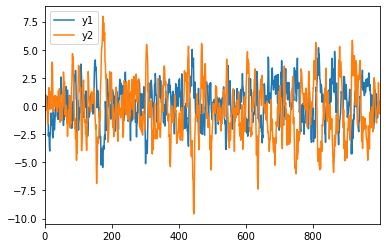

In [6]:
initial_state = [0, 0]
coefs = np.array([
       [0.8, 0], 
       [-0.5, 0.7],
]).flatten(order="C")
corr = np.array([
    [1, 0.0],
    [0.0, 1],
])
stds = [1, 1]
cov = corr2cov(corr, stds)

endog = pd.DataFrame({"y1":[np.nan, np.nan], "y2":[np.nan, np.nan]}, index=[0, 1])
mod = sm.tsa.VARMAX(endog, order=(1, 0), trend="n")
params = np.concatenate([coefs, np.sqrt(cov[np.tril_indices(cov.shape[0])])], axis=0)
print('\n'.join('{} :{}'.format(*k) for k in zip(mod.param_names, params)))
df = pd.DataFrame(mod.simulate(params=params, nsimulations=1000, initial_state=initial_state))
_ = df.plot()

## Fit a VAR model to simulated data

We "guess" lags correctly and fit a 2-variable reduced-form VAR(1) process to simualted data:

$
\begin{align*}
Y_{1,t} & = \beta_{1,1} Y_{1,t-1} + \beta_{1,2} Y_{1,t-1} + \epsilon_{1,t} \\
Y_{2,t} & = \beta_{2,1} Y_{1,t-1} + \beta_{2,2} Y_{2,t-1} + \epsilon_{2,t} \\
\end{align*}
$

For structural identification/impulse responses we use  Cholesky decomposition such that structural shock for $y_{2,t}$, $\omega_{2,t}$, does not contemporaneously affect $y_{1,t}$:

$
\begin{align*}
\begin{bmatrix} \epsilon_{1,t}  \\ \epsilon_{2,t} \end{bmatrix} = \begin{bmatrix} ? & 0 \\ ? & ? \end{bmatrix} \begin{bmatrix} \omega_{1,t} \\ \omega_{2,t} \end{bmatrix}
\end{align*}
$

Estimate VAR and similar SVAR:

In [7]:
# VAR
model_var = sm.tsa.VAR(df)
res_var = model_var.fit(maxlags=1)
irf_var = res_var.irf(5)

# SVAR
D = np.asarray([
    ["E", 0],
    ["E", "E"],
])
model_svar = sm.tsa.SVAR(df, svar_type='A', A=D)
res_svar = model_svar.fit(maxlags=1)
irf_svar = res_svar.irf(5) 

### Estimation results - cofficients and residuals

Coefficients correctly retrieved. Since the regressions model guesses DGP accurately, residuals reflect true uncorrelated DGP shocks.

In [8]:
res_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 09, Sep, 2020
Time:                     22:33:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0180542
Nobs:                     999.000    HQIC:              -0.000214638
Log likelihood:          -2823.34    FPE:                   0.988649
AIC:                   -0.0114158    Det(Omega_mle):        0.982738
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.043795         0.032206            1.360           0.174
L1.y1         0.807619         0.022851           35.343           0.000
L1.y2         0.015519         0.015565            0.997           0.319

Results for equation 

### Reduced-form residuals and structural shocks from SVAR

In [9]:
display(pd.DataFrame(np.corrcoef(res_svar.resid, rowvar=False)))
# Put structural shocks into data frame; make sure time index matches as series is of length len(df)-1
resid_structural = pd.DataFrame(np.matmul(res_svar.A, res_svar.resid.T).T, columns=df.columns, index=list(range(1, len(res_svar.resid)+1)))
display(pd.DataFrame(np.corrcoef(resid_structural, rowvar=False)))

,0,1
0,1.000000,0.023654
1,0.023654,1.000000


,0,1
0,1.000000e+00,6.005302e-07
1,6.005302e-07,1.000000e+00


In [10]:
# There is a bug in this call, chrashes!
#res_svar.summary()

### Structural impulse responses and structural impact multiplier matrix

Notice even if our identification scheme allows for $\omega_{1,t}$ to affect $y_{2,t}$, estimated effect is almost zero as should be according to DGP.

In [11]:
display(pd.DataFrame(np.linalg.inv(res_svar.A)))

,0,1
0,1.006027,0.000000
1,0.023314,0.985393


Estimated effect of w1_t on y2_t+1 is about -0.48, while true value is -0.5
Estimated effect of w1_t on y2_t+2 is about -0.72, while true value is -0.75


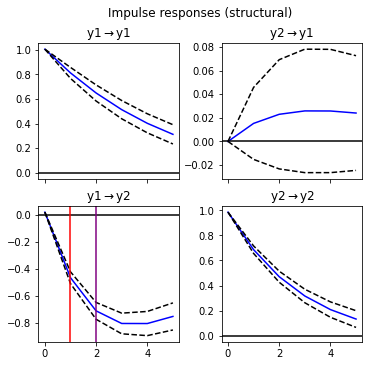

In [12]:
fig = irf_svar.plot()
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
_, _, ax, _ = fig.get_axes()
ax.axvline(x=1, c="r")
ax.axvline(x=2, c="purple")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {}".format(irf_svar.irfs[1, 1, 0], -0.5))
print("Estimated effect of w1_t on y2_t+2 is about {:.2f}, while true value is {}".format(irf_svar.irfs[2, 1, 0], -0.75))

## Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+1}$ from impulse responses with a simple linear regression

Checks out!

In [13]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["u1_l1"] = resid_structural["y1"].copy().shift(1)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ u1_l1 -1", data=gg.dropna()).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.030
Model:                            OLS   Adj. R-squared (uncentered):              0.029
Method:                 Least Squares   F-statistic:                              31.06
Date:                Wed, 09 Sep 2020   Prob (F-statistic):                    3.22e-08
Time:                        22:33:02   Log-Likelihood:                         -2299.6
No. Observations:                 998   AIC:                                      4601.
Df Residuals:                     997   BIC:                                      4606.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$ and $y_{2, t}$? We would get *direct* effect of $\omega_{1, t}$, which is estimated around zero as expected.

In [14]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + u1_l1 -1", data=gg.dropna()).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.840
Method:                 Least Squares   F-statistic:                              1747.
Date:                Wed, 09 Sep 2020   Prob (F-statistic):                        0.00
Time:                        22:33:02   Log-Likelihood:                         -1399.1
No. Observations:                 998   AIC:                                      2804.
Df Residuals:                     995   BIC:                                      2819.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

## Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+2}$ from impulse responses with a simple linear regression

Checks out!

In [15]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["u1_l2"] = resid_structural["y1"].copy().shift(2)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ u1_l2 -1", data=gg.dropna()).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.087
Model:                            OLS   Adj. R-squared (uncentered):              0.086
Method:                 Least Squares   F-statistic:                              94.81
Date:                Wed, 09 Sep 2020   Prob (F-statistic):                    1.83e-21
Time:                        22:33:02   Log-Likelihood:                         -2267.8
No. Observations:                 997   AIC:                                      4538.
Df Residuals:                     996   BIC:                                      4542.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$ and $y_{2, t}$? We would get *direct* effect of $\omega_{1, t}$, which is estimated around zero as expected.

In [16]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + u1_l2 -1", data=gg.dropna()).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.840
Method:                 Least Squares   F-statistic:                              1746.
Date:                Wed, 09 Sep 2020   Prob (F-statistic):                        0.00
Time:                        22:33:02   Log-Likelihood:                         -1398.1
No. Observations:                 997   AIC:                                      2802.
Df Residuals:                     994   BIC:                                      2817.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------